In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm
import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [42]:
train_size = 0.9
lr = 1e-3
eps = 1e-8
batch_size = 512
epochs = 20

Dataset

In [5]:
def mnist(train_part, transform=None):
    dataset = torchvision.datasets.MNIST('.', download=True, transform=transform)
    train_part = int(train_part * len(dataset))
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_part, len(dataset) - train_part])
    return train_dataset, test_dataset

In [6]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset, test_dataset = mnist(train_size, transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, drop_last=True, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
dataloaders = (train_dataloader, test_dataloader)

100%|██████████| 9912422/9912422 [00:00<00:00, 101163847.94it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 44388308.47it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 25999884.95it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7470795.60it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



The Model

In [43]:
class VAEEncoder(nn.Module):
    def __init__(self):
        super(VAEEncoder, self).__init__()
        self.intermediate_dim = 512
        self.latent_dim = 2
        self.linear = nn.Linear(784, self.intermediate_dim)
        self.z_mean = nn.Linear(self.intermediate_dim, self.latent_dim)
        self.z_log = nn.Linear(self.intermediate_dim, self.latent_dim)
        self.relu = nn.ReLU()

    def forward(self, input):
        bs = input.shape[0]

        hidden = self.relu(self.linear(input))
        z_mean = self.z_mean(hidden)
        z_log = self.z_log(hidden)

        eps = torch.randn(bs, self.latent_dim, device=input.device)
        z_val = z_mean + torch.exp(z_log) * eps
        return z_mean, z_log, z_val

In [44]:
class VAEDecoder(nn.Module):
    def __init__(self):
        super(VAEDecoder, self).__init__()
        self.intermediate_dim = 512
        self.latent_dim = 2
        self.linear = nn.Linear(self.latent_dim, self.intermediate_dim)
        self.output = nn.Linear(self.intermediate_dim, 784)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        hidden = self.relu(self.linear(input))
        decoded = self.sigmoid(self.output(hidden))
        return decoded

In [45]:
class VAEAutoEncoder(nn.Module):
    def __init__(self):
        super(VAEAutoEncoder, self).__init__()
        self.encoder = VAEEncoder()
        self.decoder = VAEDecoder()
        #self.z_vals = None

    def forward(self, input):
        bs, c, h, w = input.shape[0], input.shape[1], input.shape[2], input.shape[3]
        input = input.view(bs, -1)
        z_mean, z_log, z_val = self.encoder(input)
        #self.z_vals = encoded
        decoded = self.decoder(z_val)
        return decoded , z_mean, z_log, z_val

Loss

In [46]:
def vae_loss(preds, targets, z_mean, z_log, z_val):
    mse = nn.MSELoss()
    reconstruction_loss = mse(preds, targets.view(targets.shape[0], -1)) * 784.0
    temp = 1.0 + z_log - torch.square(z_mean) - torch.exp(z_log)
    kl_loss = -0.5 * torch.sum(temp, axis=-1)
    return torch.mean(reconstruction_loss + kl_loss)

In [47]:
model = VAEAutoEncoder()

if torch.cuda.device_count() > 1:
    print(f"using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

using 2 GPUs


DataParallel(
  (module): VAEAutoEncoder(
    (encoder): VAEEncoder(
      (linear): Linear(in_features=784, out_features=512, bias=True)
      (z_mean): Linear(in_features=512, out_features=2, bias=True)
      (z_log): Linear(in_features=512, out_features=2, bias=True)
      (relu): ReLU()
    )
    (decoder): VAEDecoder(
      (linear): Linear(in_features=2, out_features=512, bias=True)
      (output): Linear(in_features=512, out_features=784, bias=True)
      (relu): ReLU()
      (sigmoid): Sigmoid()
    )
  )
)

In [48]:
optimizer = optim.RMSprop(model.parameters(), lr=lr, eps=eps)

In [49]:
def train_vae(dataloaders, model, optimizer, epochs, device):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader, test_dataloader = dataloaders[0], dataloaders[1]
    epoch_train_losses = []

    for epoch in tqdm_iter:
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch in train_dataloader:
            imgs, _ = batch  
            imgs = imgs.to(device)

            optimizer.zero_grad()

            preds,z_mean, z_log, z_val = model(imgs)
            
            #print(preds.shape)
            #print(z_val.shape)
            loss = vae_loss(preds, imgs, z_mean, z_log, z_val)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for batch in test_dataloader:
                imgs, _ = batch
                imgs = imgs.to(device)

                preds,z_mean, z_log, z_val = model(imgs)
                
                loss = vae_loss(preds, imgs, z_mean, z_log, z_val)

                test_loss += loss.item()

        train_loss /= len(train_dataloader)
        test_loss /= len(test_dataloader)
        
        epoch_train_losses.append(train_loss)

        tqdm_dct = {'train loss': train_loss, 'test loss': test_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()
        
    plt.figure(figsize=(5, 5))
    plt.plot(range(1, epochs + 1), epoch_train_losses, label='Train Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

100%|██████████| 20/20 [07:12<00:00, 21.64s/it, train loss=36.5, test loss=36.9]


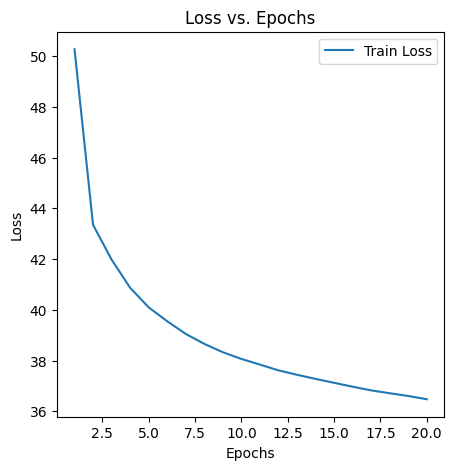

In [50]:
train_vae(dataloaders, model, optimizer, epochs, device)

In [51]:
def plotn(n, data):
    fig, ax = plt.subplots(1, n)
    for i, z in enumerate(data):
        if i == n:
            break
        preprocess = z[0].reshape(1, 28, 28)
        ax[i].imshow(preprocess[0],cmap ='gray')
        ax[i].axis('off')
    plt.show()

torch.Size([1, 784])
<class 'torch.Tensor'>
torch.Size([1, 784])
<class 'torch.Tensor'>
torch.Size([1, 784])
<class 'torch.Tensor'>
torch.Size([1, 784])
<class 'torch.Tensor'>
torch.Size([1, 784])
<class 'torch.Tensor'>
torch.Size([1, 784])
<class 'torch.Tensor'>
torch.Size([1, 784])
<class 'torch.Tensor'>
torch.Size([1, 784])
<class 'torch.Tensor'>
torch.Size([1, 784])
<class 'torch.Tensor'>
torch.Size([1, 784])
<class 'torch.Tensor'>


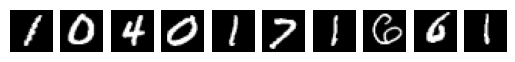

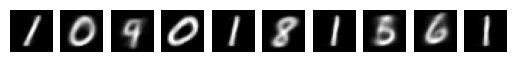

In [52]:
model.eval()
predictions = []
plots = 10
for i, data in enumerate(test_dataset):
    if i == plots:
        break
        
    output_imgs = model(data[0].to(device).unsqueeze(0))
    print(output_imgs[0].shape)
    print(type(output_imgs[0]))
    op_img = output_imgs[0].view(1, 28, 28)
    predictions.append(op_img.detach().cpu())
plotn(plots, test_dataset)
plotn(plots, predictions)

# The Latent Space

6000
6000
6000


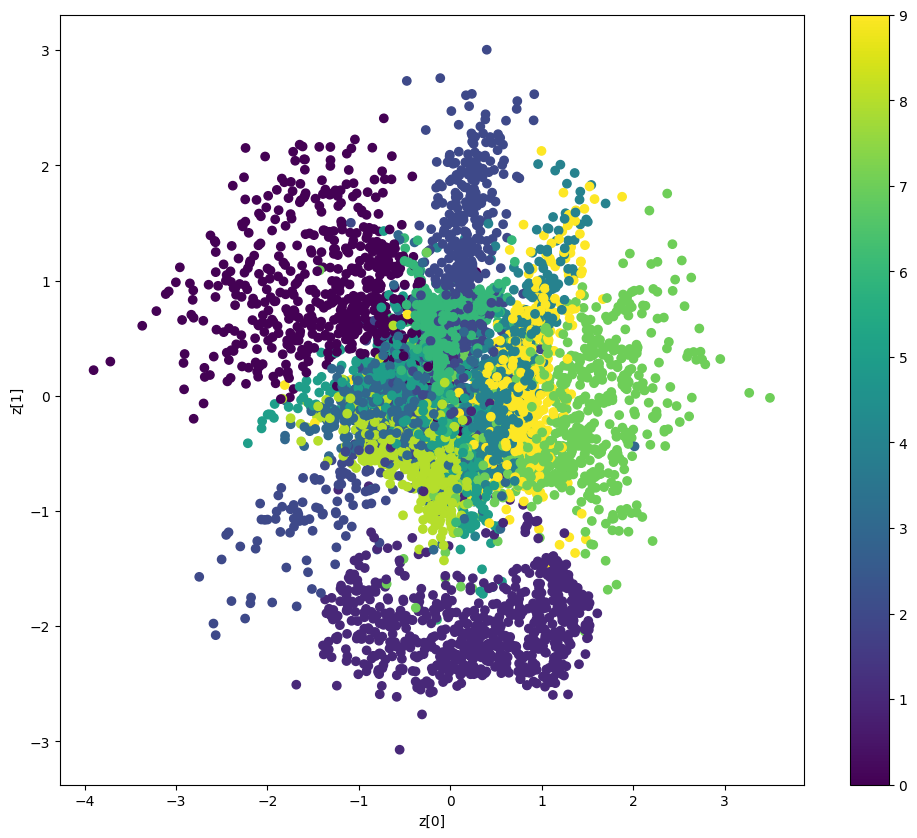

In [53]:
z_mean0 = []
z_mean1 = []
c = []
for x, y in test_dataset:
    output_imgs = model(x.to(device).unsqueeze(0))
    z_mean = output_imgs[1].detach().cpu().numpy()
    z_mean0.append(z_mean[0][0])
    z_mean1.append(z_mean[0][1])
    c.append(y)  
print(len(z_mean0))
print(len(z_mean1))
print(len(c))

plt.figure(figsize=(12, 10))
plt.scatter(z_mean0, z_mean1, c=c)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

# Sampling from this simple latent distribution and generating images

In [54]:
oyeboy = torch.tensor([0,-2]).unsqueeze(0)
print(oyeboy.shape)

torch.Size([1, 2])


In [55]:
chek = model.module.decoder(oyeboy.to(device).float())
chek = chek.view(1, 28, 28)
chek = chek.detach().cpu()

<function matplotlib.pyplot.show(close=None, block=None)>

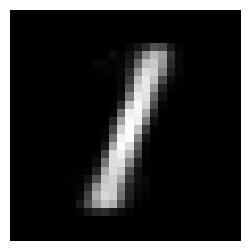

In [56]:
fig, ax = plt.subplots(1, 1,figsize=(3, 3))
ax.imshow(chek[0],cmap ='gray')
ax.axis('off')
plt.show

we can see the area 0,-2 in the latent space cluster and see which digits are present 